In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [17]:
mens_pfp_df = pd.read_csv('men_data.csv')
fight_data_df = pd.read_csv('ufc1_cleaned_data.csv')

In [18]:
df_rankings = mens_pfp_df.melt(id_vars=["Date"], var_name="Rank", value_name="Name")
df_rankings = df_rankings.dropna(subset=["Name"])
df_rankings["Name"] = df_rankings["Name"].str.upper().str.strip()

In [19]:
fight_data_df["fighter_clean"] = fight_data_df["fighter"].str.upper().str.strip()

fight_data_df["date"] = pd.to_datetime(fight_data_df["date"], errors="coerce")
df_rankings["Date"] = pd.to_datetime(df_rankings["Date"], errors="coerce")

df_rankings = df_rankings.dropna(subset=["Date"])
fight_data_df = fight_data_df.dropna(subset=["date"])

df_rankings["Name"] = df_rankings["Name"].str.upper().str.strip()
fight_data_df["fighter_clean"] = fight_data_df["fighter"].str.upper().str.strip()

df_rankings = df_rankings.sort_values("Date")
ufc_df = fight_data_df.sort_values("date")

In [20]:
merged_ufc_df = pd.merge_asof(
    ufc_df,
    df_rankings.rename(columns={"Date": "ranking_date", "Name": "fighter_clean"}),
    by="fighter_clean",
    left_on="date",
    right_on="ranking_date",
    direction="backward"
)

In [21]:
merged_ufc_df["result_binary"] = merged_ufc_df["result"].map({
    "Win": 1,
    "Loss": 0
})

merged_ufc_df["fight_year"] = merged_ufc_df["date"].dt.year
merged_ufc_df["rank_normalized"] = StandardScaler().fit_transform(merged_ufc_df[["Rank"]])

model_df = merged_ufc_df.dropna(subset=["Rank", "result_binary", "date"])
model_df["fight_year"] = model_df["date"].dt.year

merged_ufc_df["date"] = pd.to_datetime(merged_ufc_df["date"], errors="coerce")
merged_ufc_df = merged_ufc_df.sort_values(by=["fighter_clean", "date"])

merged_ufc_df["days_since_last_fight"] = merged_ufc_df.groupby("fighter_clean")["date"].diff().dt.days

/var/folders/bj/d71x7qnx3s5cdq0hnq7fshg80000gn/T/ipykernel_6808/2836766277.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["fight_year"] = model_df["date"].dt.year


In [22]:
def parse_time(t):
    try:
        mins, secs = map(int, t.split(":"))
        return mins * 60 + secs
    except:
        return np.nan

merged_ufc_df["time_seconds_left"] = merged_ufc_df["time"].apply(parse_time)

merged_ufc_df["fight_progress_seconds"] = (
    (merged_ufc_df["round"] - 1) * 300 + (300 - merged_ufc_df["time_seconds_left"])
)

In [23]:
merged_ufc_df.head(5)

,fighter,opponent,reach,result,record,method,event,date,round,time,opponent_in_data,fighter_clean,ranking_date,Rank,result_binary,fight_year,rank_normalized,days_since_last_fight,time_seconds_left,fight_progress_seconds
1269,Aaron Brink,Ali Afra,191 cm,Win,1–0,KO (punches),WCNHBC: West Coast NHB Championships 1,1998-12-08,1.0,0:54,False,AARON BRINK,NaT,NaN,1.0,1998,NaN,NaN,54.0,246.0
1271,Aaron Brink,Al Harlow,191 cm,Win,2–0,KO (knee),WCNHBC: West Coast NHB Championships 1,1998-12-08,1.0,1:24,False,AARON BRINK,NaT,NaN,1.0,1998,NaN,0.0,84.0,216.0
1517,Aaron Brink,Al Harlow,191 cm,Win,3–0,KO,WCNHBC: West Coast NHB Championships 3,1999-06-06,NaN,NaN,False,AARON BRINK,NaT,NaN,1.0,1999,NaN,180.0,NaN,NaN
1810,Aaron Brink,Gan Mcgee,191 cm,Loss,3–1,TKO (submission to punches),CFF: The Cobra Challenge 1999,1999-12-11,1.0,3:09,True,AARON BRINK,NaT,NaN,0.0,1999,NaN,188.0,189.0,111.0
2116,Aaron Brink,Harry Moskowitz,191 cm,Win,4–1,TKO (punches),Rings USA: Rising Stars Block A,2000-07-15,1.0,0:47,True,AARON BRINK,NaT,NaN,1.0,2000,NaN,217.0,47.0,253.0


### General Description of the Data
- Understand the dataset as a whole: number of rows, columns, data types, missing values.
- Understand what each feature represents (semantic meaning and data type).
- Identify categorical vs. numerical variables.

In [24]:
# Check for number of rows and columns
merged_ufc_df.shape

(35800, 20)

In [25]:
# Check for data types
merged_ufc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35800 entries, 1269 to 33895
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fighter                 35800 non-null  object        
 1   opponent                35800 non-null  object        
 2   reach                   29746 non-null  object        
 3   result                  35772 non-null  object        
 4   record                  35797 non-null  object        
 5   method                  35751 non-null  object        
 6   event                   35775 non-null  object        
 7   date                    35800 non-null  datetime64[ns]
 8   round                   35578 non-null  float64       
 9   time                    34499 non-null  object        
 10  opponent_in_data        35800 non-null  bool          
 11  fighter_clean           35800 non-null  object        
 12  ranking_date            335 non-null    datetime

In [26]:
# check for total null
merged_ufc_df.isnull().sum()

fighter                       0
opponent                      0
reach                      6054
result                       28
record                        3
method                       49
event                        25
date                          0
round                       222
time                       1301
opponent_in_data              0
fighter_clean                 0
ranking_date              35465
Rank                      35465
result_binary               828
fight_year                    0
rank_normalized           35465
days_since_last_fight      1380
time_seconds_left          1308
fight_progress_seconds     1310
dtype: int64

### Semantic meaning of each feature:
- Categorical:
  - fighter: The name of the fighter whose stats or match result this row represents
  - opponent: The name of the opponent the fighter faced
  - result: The fight outcome for the fighter (e.g., "Win", "Loss", "Draw", "No Contest")
  - record: The fighter's career win-loss record after this fight
  - method: The way the fight ended
  - event: The official title of the MMA event or fight card where the match took place
  - date: The date the fight happened

- Numerical:
  - reach: The arm reach of the fighter (usually in inches), which can affect striking range
  - round: The round in which the fight ended
  - time: The time within the round the fight ended

### Single-Dimension (Univariate) Analysis
- Analyze the distribution of each individual feature.
- Check value ranges, central tendencies (mean, median), and dispersion (standard deviation, IQR).
- Detect and handle outliers.
- Identify missing or imbalanced values (especially for categorical features).

In [27]:
# round_duration_seconds = time_seconds_left + time_in_round
merged_ufc_df["round_duration_seconds"] = merged_ufc_df["time_seconds_left"] + merged_ufc_df["fight_progress_seconds"]
# ratio of time_seconds_left to round_duration_seconds
merged_ufc_df["time_left_ratio"] = merged_ufc_df["time_seconds_left"] / merged_ufc_df["round_duration_seconds"]

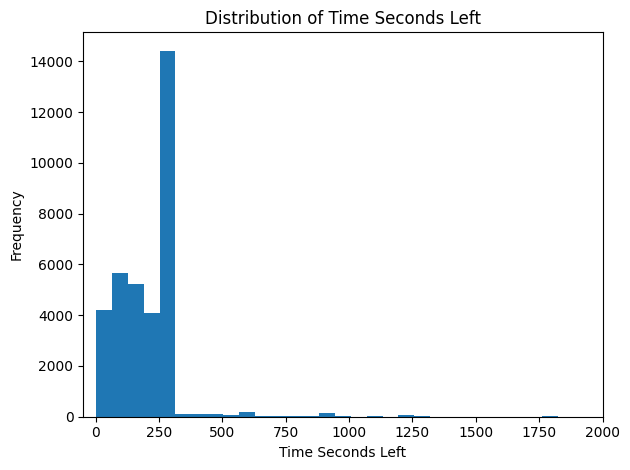

In [28]:
plt.hist(merged_ufc_df["time_seconds_left"], bins=50)
plt.xlabel("Time Seconds Left")
plt.ylabel("Frequency")
plt.title("Distribution of Time Seconds Left")
plt.xlim(-50, 2000)
plt.tight_layout()
plt.show()

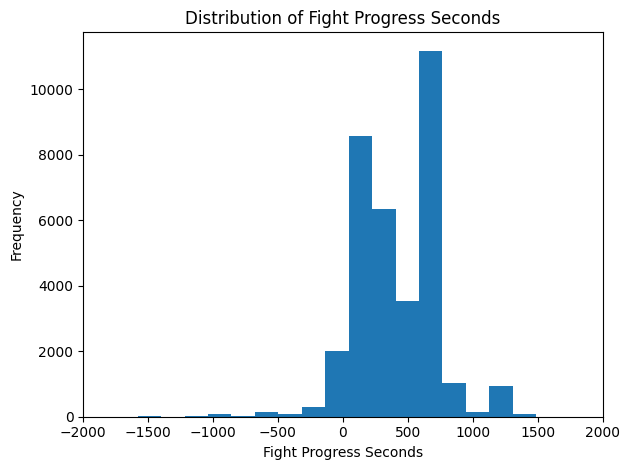

In [29]:
plt.hist(merged_ufc_df["fight_progress_seconds"], bins=50)
plt.xlabel("Fight Progress Seconds")
plt.ylabel("Frequency")
plt.title("Distribution of Fight Progress Seconds")
plt.xlim(-2000, 2000)
plt.tight_layout()
plt.show()

In [30]:
merged_ufc_df["time_left_ratio"].describe()

count    34477.000000
mean         0.418102
std          0.435716
min          0.000000
25%          0.226667
50%          0.333333
75%          0.470000
max         10.480000
Name: time_left_ratio, dtype: float64

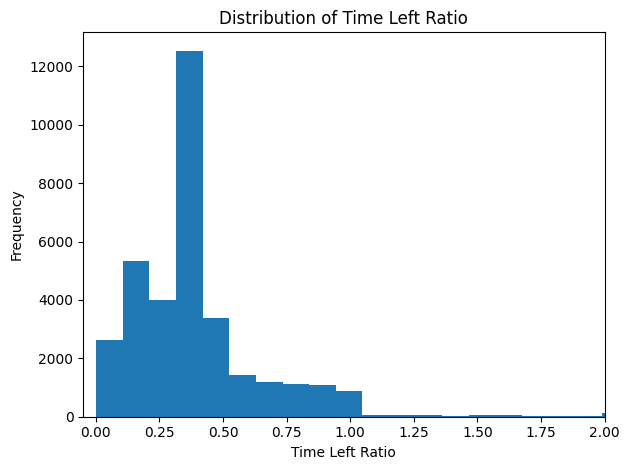

In [31]:
plt.hist(merged_ufc_df["time_left_ratio"], bins=100)
plt.xlabel("Time Left Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Time Left Ratio")
plt.xlim(-.05, 2)
plt.gca().get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.tight_layout()
plt.show()

In [32]:
merged_ufc_df['wins'] = merged_ufc_df['record'].str.extract(r'(\d+)(?=–)').astype(float)
merged_ufc_df['losses'] = merged_ufc_df['record'].str.extract(r'–(\d+)').astype(float)

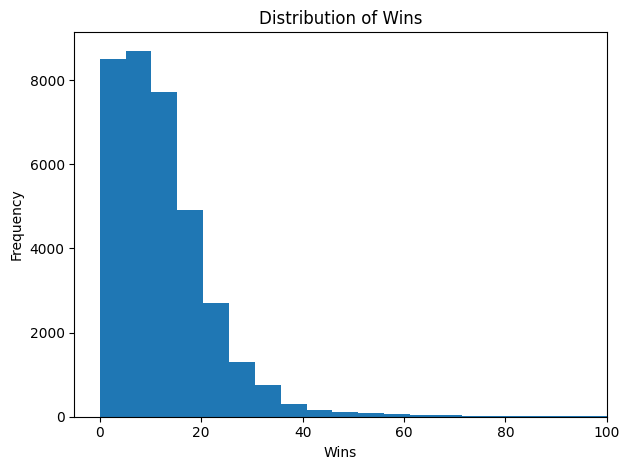

In [33]:
plt.hist(merged_ufc_df["wins"], bins=50)
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.title("Distribution of Wins")
plt.xlim(-5, 100)
plt.tight_layout()
plt.show()

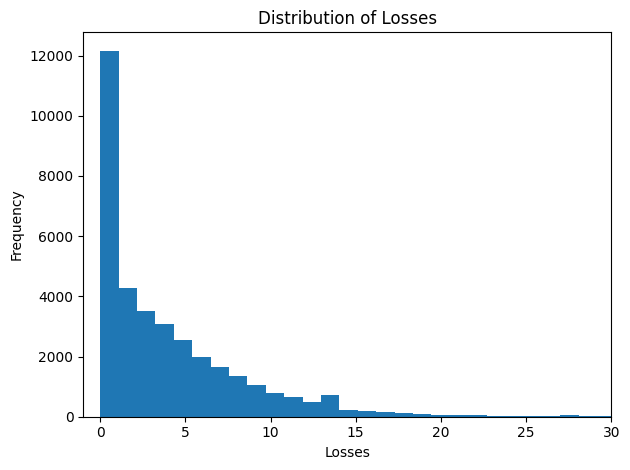

In [34]:
plt.hist(merged_ufc_df["losses"], bins=50)
plt.xlabel("Losses")
plt.ylabel("Frequency")
plt.title("Distribution of Losses")
plt.xlim(-1, 30)
plt.tight_layout()
plt.show()

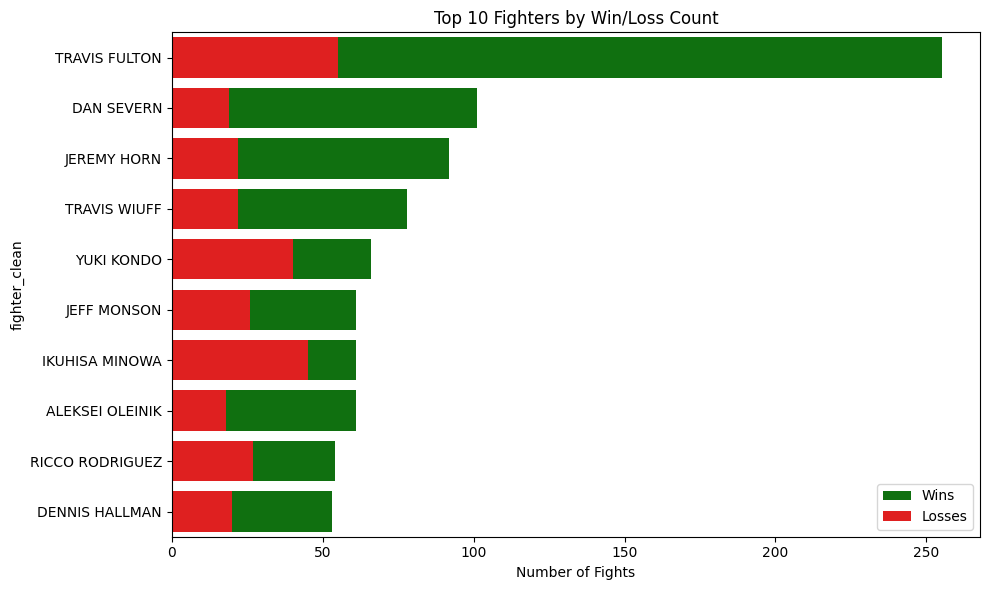

In [35]:
# How many wins/losses per fighter
win_loss_counts = merged_ufc_df.groupby(['fighter_clean', 'result']).size().unstack(fill_value=0)

# Win/loss ratio
win_loss_counts['win_loss_ratio'] = win_loss_counts.get('Win', 0) / (win_loss_counts.get('Loss', 1))

# Top 10 win counts
top_win_counts = win_loss_counts.sort_values(by='Win', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(y=top_win_counts.index, x=top_win_counts['Win'], color='green', label='Wins')
sns.barplot(y=top_win_counts.index, x=top_win_counts['Loss'], color='red', label='Losses')
plt.title("Top 10 Fighters by Win/Loss Count")
plt.xlabel("Number of Fights")
plt.legend()
plt.tight_layout()
plt.show()

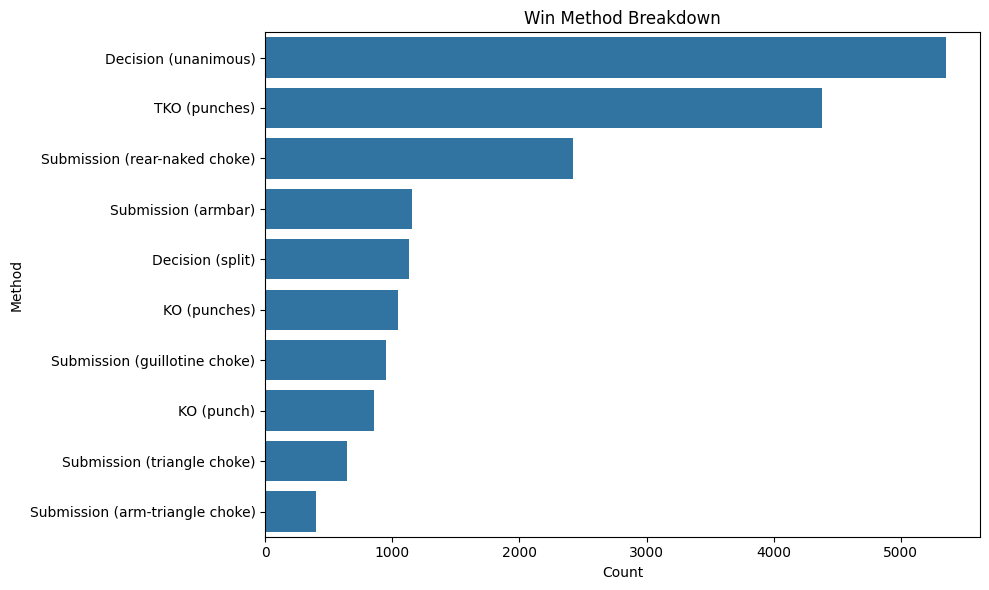

In [36]:
method_counts = merged_ufc_df[merged_ufc_df['result'] == 'Win']['method'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=method_counts.values, y=method_counts.index)
plt.title("Win Method Breakdown")
plt.xlabel("Count")
plt.ylabel("Method")
plt.tight_layout()
plt.show()

### Multiple-Dimension (Multivariate) Analysis
- Investigate relationships between features: correlation matrix, scatterplots, pairplots.
- Compare features with the target variable (if supervised learning): group comparisons, boxplots, etc.
- Consider feature interactions.